In [ ]:
import numpy as np 
import pandas as pd
from scipy.spatial.distance import euclidean
from sklearn.base import BaseEstimator,ClassifierMixin
from sklearn.model_selection import train_test_split
import fastdtw
#dtw for comparing two sequences and calculating the optimal matchinh between two sequences
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.signal import butter, lfilter, freqz, boxcar
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, euclidean_distances
from scipy.fftpack import fft, ifft
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_data = pd.read_csv("/content/gdrive/MyDrive/EEG_Signal_Based_UpperLimb_Motion_Recognition&Control/Datasets/Kaggle-Hand lift and grasp/train/subj1_series1_data.csv")
train_data_event = pd.read_csv("/content/gdrive/MyDrive/EEG_Signal_Based_UpperLimb_Motion_Recognition&Control/Datasets/Kaggle-Hand lift and grasp/train/subj1_series1_events.csv")
test_data = pd.read_csv("/content/gdrive/MyDrive/EEG_Signal_Based_UpperLimb_Motion_Recognition&Control/Datasets/Kaggle-Hand lift and grasp/test/subj1_series10_data.csv")
test_data_event = pd.read_csv("/content/gdrive/MyDrive/EEG_Signal_Based_UpperLimb_Motion_Recognition&Control/Datasets/Kaggle-Hand lift and grasp/test/subj1_series9_data.csv")

In [ ]:
train_complete = pd.concat([train_data,train_data_event], axis=1)
train_complete.insert(0, "order", range(0, len(train_complete)))
train_complete

,order,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,0,subj1_series1_0,-31,363,211,121,211,15,717,279,35,158,543,-166,192,230,573,860,128,59,272,473,325,379,536,348,383,105,607,289,459,173,120,704,subj1_series1_0,0,0,0,0,0,0
1,1,subj1_series1_1,-29,342,216,123,222,200,595,329,43,166,495,-138,201,233,554,846,185,47,269,455,307,368,529,327,369,78,613,248,409,141,83,737,subj1_series1_1,0,0,0,0,0,0
2,2,subj1_series1_2,-172,278,105,93,222,511,471,280,12,177,534,-163,198,207,542,768,145,52,250,452,273,273,511,319,355,66,606,320,440,141,62,677,subj1_series1_2,0,0,0,0,0,0
3,3,subj1_series1_3,-272,263,-52,99,208,511,428,261,27,180,525,-310,212,221,542,808,115,41,276,432,258,241,521,336,356,71,568,339,437,139,58,592,subj1_series1_3,0,0,0,0,0,0
4,4,subj1_series1_4,-265,213,-67,99,155,380,476,353,32,165,507,-320,242,230,545,865,180,89,288,444,275,275,550,324,346,76,547,343,446,171,67,581,subj1_series1_4,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119491,119491,subj1_series1_119491,478,520,377,172,141,118,-123,626,70,40,9,-95,73,-89,233,292,-85,-38,74,-34,2,-305,383,85,-1,444,337,-255,160,-121,-285,-178,subj1_series1_119491,0,0,0,0,0,0
119492,119492,subj1_series1_119492,439,450,298,185,128,502,-331,593,30,54,256,-224,49,-99,264,304,-210,-59,63,-19,10,-283,334,61,-8,427,322,-310,107,-152,-295,-178,subj1_series1_119492,0,0,0,0,0,0
119493,119493,subj1_series1_119493,363,370,278,239,124,768,-410,527,16,72,253,-394,35,-134,241,104,-164,-52,45,-45,16,-185,303,53,-24,438,368,-134,187,-99,-269,-121,subj1_series1_119493,0,0,0,0,0,0
119494,119494,subj1_series1_119494,281,298,318,257,130,736,-556,542,29,67,184,-260,42,-112,232,-168,-119,-30,54,-51,26,-177,341,50,-25,444,348,-135,181,-122,-290,-77,subj1_series1_119494,0,0,0,0,0,0


In [ ]:
df = pd.DataFrame(train_complete)

In [ ]:
new_data = df.drop(['id','Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7','T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P8', 'PO9','O1','Oz','O2','O2','PO10'], axis = 1)
new_data

,order,C3,Cz,C4,P3,Pz,P4,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,0,192,230,573,348,383,105,0,0,0,0,0,0
1,1,201,233,554,327,369,78,0,0,0,0,0,0
2,2,198,207,542,319,355,66,0,0,0,0,0,0
3,3,212,221,542,336,356,71,0,0,0,0,0,0
4,4,242,230,545,324,346,76,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119491,119491,73,-89,233,85,-1,444,0,0,0,0,0,0
119492,119492,49,-99,264,61,-8,427,0,0,0,0,0,0
119493,119493,35,-134,241,53,-24,438,0,0,0,0,0,0
119494,119494,42,-112,232,50,-25,444,0,0,0,0,0,0


In [ ]:
C3= train_data.loc[:,"C3"]
C3



0         192
1         201
2         198
3         212
4         242
         ... 
119491     73
119492     49
119493     35
119494     42
119495     38
Name: C3, Length: 119496, dtype: int64

In [ ]:
C4= train_data.loc[:,"C4"]
C4

0         573
1         554
2         542
3         542
4         545
         ... 
119491    233
119492    264
119493    241
119494    232
119495    238
Name: C4, Length: 119496, dtype: int64

In [ ]:
Cz= train_data.loc[:,"Cz"]
Cz

0         230
1         233
2         207
3         221
4         230
         ... 
119491    -89
119492    -99
119493   -134
119494   -112
119495   -113
Name: Cz, Length: 119496, dtype: int64

In [ ]:
P3= train_data.loc[:,"P3"]
P3

0         348
1         327
2         319
3         336
4         324
         ... 
119491     85
119492     61
119493     53
119494     50
119495     75
Name: P3, Length: 119496, dtype: int64

In [ ]:
P4= train_data.loc[:,"P4"]
P4

0         105
1          78
2          66
3          71
4          76
         ... 
119491    444
119492    427
119493    438
119494    444
119495    460
Name: P4, Length: 119496, dtype: int64

In [ ]:
Pz = train_data.loc[:,"Pz"]
Pz

0         383
1         369
2         355
3         356
4         346
         ... 
119491     -1
119492     -8
119493    -24
119494    -25
119495     -3
Name: Pz, Length: 119496, dtype: int64

### HandStart

In [ ]:
HS = new_data.loc[:,"HandStart"]
HS

0         0
1         0
2         0
3         0
4         0
         ..
119491    0
119492    0
119493    0
119494    0
119495    0
Name: HandStart, Length: 119496, dtype: int64

[313, 290, 303, 326, 343, 329, 311, 311, 325, 305, 330, 322, 346, 350, 371, 392, 362, 345, 376, 338, 325, 329, 349, 357, 381, 415, 418, 432, 446, 439, 365, 413, 426, 409, 401, 411, 431, 410, 407, 467, 410, 444, 458, 431, 439, 420, 424, 446, 425, 444, 457, 448, 421, 421, 477, 486, 494, 504, 481, 478, 476, 446, 440, 485, 465, 457, 505, 426, 436, 462, 443, 433, 494, 503, 502, 490, 480, 476, 473, 443, 443, 491, 477, 491, 468, 463, 440, 459, 465, 429, 451, 452, 434, 448, 440, 433, 466, 453, 394, 364, 381, 393, 378, 371, 360, 413, 426, 395, 395, 431, 453, 431, 419, 453, 496, 463, 386, 439, 375, 372, 396, 401, 411, 383, 365, 392, 387, 364, 389, 445, 413, 372, 377, 393, 380, 349, 357, 377, 382, 397, 387, 391, 396, 367, 368, 376, 366, 358, 351, 335, 364, 396, 356, 384, 410, 388, 395, 366, 323, 314, 314, 313, 353, 335, 354, 372, 375, 387, 390, 403, 361, 341, 351, 369, 346, 325, 325, 316, 370, 346, 357, 349, 359, 381, 368, 375, 397, 408, 312, 276, 317, 318, 367, 391, 430, 403, 399, 396, 371, 382,

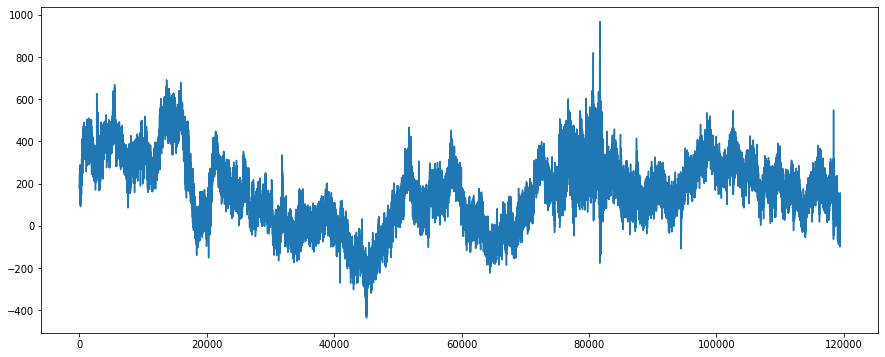

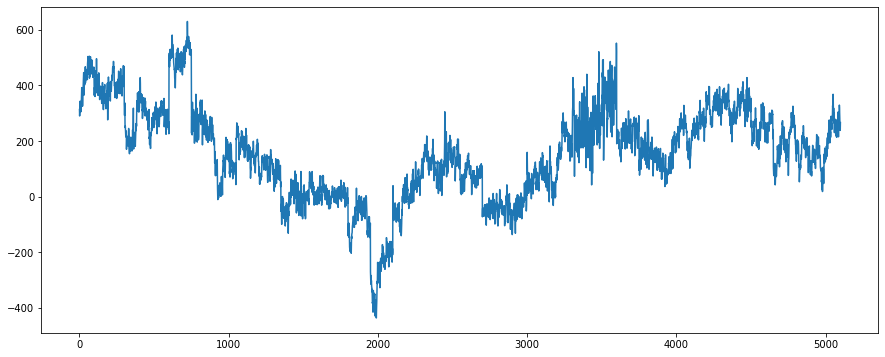

In [ ]:
C3_handstart = []
for i in range(119495):
  if HS[i] == 1:
    C3_handstart.append(C3[i])
 
print(C3_handstart)

fig = plt.figure(figsize=(15, 6))
plt.plot(C3)

fig = plt.figure(figsize=(15, 6))
plt.plot(C3_handstart)

## Bandpass Filter (ButterWorth  Filter)

<Figure size 1440x432 with 0 Axes>

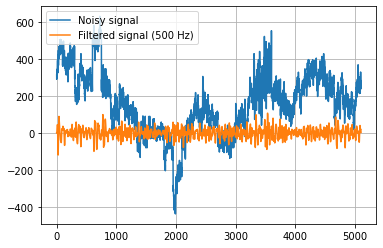

<Figure size 2160x720 with 0 Axes>

In [ ]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 500
lowcut = 7
highcut = 30

# Filter a noisy signal.
#nsamples = int(T * fs)
f0 = 500.0
figure = plt.figure(figsize=(20, 6))
plt.figure(2)
plt.clf()
plt.plot( C3_handstart, label='Noisy signal')

y = butter_bandpass_filter(C3_handstart, lowcut, highcut, fs, order=6)

plt.plot( y, label='Filtered signal (%g Hz)' % f0)
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
#plt.figure(figsize=(40, 10))
plt.show()

#resizing
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
#plt.plot(y, label='Filtered signal (%g Hz)' % f0)
plt.show()

## Feature Extraction

In [ ]:
print(len(y))

5100


In [ ]:
from scipy.stats import norm, kurtosis
from scipy.stats import skew
import statistics

In [ ]:
y = np.array(y)
import statistics

median = np.median(y)
mean = y.mean()
var = statistics.variance(y)
std_dev = var ** 0.5
kurtosis = kurtosis(y)
skewness = skew(y)
peak2peak = max(y)-min(y)

print("variance = ", var)
print("median = ",median)
print("mean = ", mean)
print("Standard Deviation = ", std_dev)
print("kurtosis = ",kurtosis)
print("skewness = ", skewness)
print("Peak to peak = ", peak2peak)

variance =  803.9552794451694
median =  0.7050390423177755
mean =  0.03285515942227735
Standard Deviation =  28.354105160367332
kurtosis =  0.5837227113134342
skewness =  -0.1395688287976822
Peak to peak =  225.85513773624336


In [ ]:
!pip install mne

In [ ]:
pip install mne-features

In [ ]:
pip install numpy matplotlib scipy numba scikit-learn mne PyWavelets pandas

In [ ]:
pip install git+https://github.com/mne-tools/mne-features.git#egg=mne_features

  Cloning https://github.com/mne-tools/mne-features.git to /tmp/pip-install-8ihwd_pd/mne-features_4cb42d3c271145c5bbd442e2159ed28d
  Running command git clone -q https://github.com/mne-tools/mne-features.git /tmp/pip-install-8ihwd_pd/mne-features_4cb42d3c271145c5bbd442e2159ed28d


In [ ]:
import mne

In [ ]:
import mne_features

In [ ]:
#mean
mne_features.univariate.compute_mean(y)

0.03285515942227735

In [ ]:
#median
median = np.median(y)
median

0.7050390423177755

In [ ]:
#variance
mne_features.univariate.compute_variance(y)

803.9552794451694

In [ ]:
#std deviation
mne_features.univariate.compute_std(y)

28.354105160367332

In [ ]:
#kurtosis
mne_features.univariate.compute_kurtosis(y)

3.5837227113134342

In [ ]:
#skewness
mne_features.univariate.compute_skewness(y)

-0.1395688287976822

In [ ]:
#peak to peak
mne_features.univariate.compute_ptp_amp(y)

225.85513773624336

In [ ]:
#rms
mne_features.univariate.compute_rms(y)

28.351344247082583

In [ ]:
import mne
#Freqeuncy Domain
#power spectrum density
mne_features.utils.power_spectrum(500,y)


(array([8.24272135e-02, 6.38819982e-02, 1.00531809e+00, 2.86996243e+01,
        8.54861100e+01, 7.47159622e+01, 3.16601251e+01, 2.35152277e+01,
        1.95536694e+01, 3.07349596e+01, 3.03038776e+01, 2.21556784e+01,
        1.71924438e+01, 1.50674745e+01, 1.06907180e+01, 6.12933884e+00,
        5.64321976e+00, 2.88974818e+00, 5.31694408e-01, 2.55040780e-01,
        1.35833535e-01, 4.97131170e-02, 1.63094146e-02, 6.66103445e-03,
        5.61164160e-03, 3.02527044e-03, 2.55283050e-03, 1.65603322e-03,
        1.03421363e-03, 1.09948025e-03, 8.08231282e-04, 8.42175885e-04,
        7.27537142e-04, 6.07855759e-04, 6.92193660e-04, 5.23322851e-04,
        5.20338146e-04, 5.09932879e-04, 4.25499010e-04, 4.42998342e-04,
        3.84261029e-04, 4.07427621e-04, 3.58754183e-04, 3.32074966e-04,
        3.49493012e-04, 3.04159005e-04, 3.02496747e-04, 2.88177506e-04,
        2.77801454e-04, 2.65572987e-04, 2.53710165e-04, 2.46998935e-04,
        2.35173093e-04, 2.28473071e-04, 2.21647900e-04, 2.120505

In [ ]:
#

In [ ]:
pip install antropy

In [ ]:
import numpy as np
import antropy as ant

# Spectral entropy
print(ant.spectral_entropy(y, sf=500, method='welch', normalize=True))

0.5153421387490259


In [ ]:
# Approximate entropy
print(ant.app_entropy(y))

0.6125706393407859


In [ ]:
# Number of zero-crossings
print(ant.num_zerocross(y))

320


In [ ]:
#zero crossing
import numpy

zs = numpy.where(numpy.diff(numpy.sign(y)))[0]
zs

array([  17,   30,   56,   84,  124,  140,  147,  152,  184,  194,  199,
        222,  236,  250,  265,  287,  310,  319,  333,  358,  396,  414,
        446,  470,  498,  515,  544,  573,  602,  610,  616,  631,  660,
        684,  714,  745,  759,  765,  779,  805,  827,  842,  848,  867,
        893,  897,  913,  925,  932,  945,  953,  962,  980,  987, 1000,
       1018, 1029, 1041, 1052, 1057, 1068, 1082, 1099, 1120, 1129, 1139,
       1152, 1161, 1170, 1186, 1202, 1217, 1234, 1253, 1286, 1311, 1330,
       1357, 1359, 1364, 1378, 1408, 1425, 1430, 1438, 1452, 1460, 1472,
       1482, 1488, 1495, 1506, 1518, 1528, 1538, 1550, 1556, 1568, 1596,
       1621, 1628, 1633, 1647, 1657, 1666, 1695, 1709, 1718, 1735, 1764,
       1788, 1797, 1808, 1819, 1834, 1856, 1889, 1923, 1938, 1941, 1955,
       1968, 1981, 2002, 2014, 2020, 2037, 2060, 2068, 2083, 2101, 2107,
       2116, 2130, 2151, 2166, 2176, 2193, 2214, 2220, 2228, 2254, 2270,
       2274, 2286, 2297, 2302, 2318, 2362, 2391, 24

In [ ]:
len(zs)

320

### **C4 Channel**

[598, 594, 581, 590, 607, 606, 579, 568, 584, 592, 566, 564, 544, 568, 558, 554, 559, 559, 572, 551, 595, 628, 657, 659, 669, 673, 645, 680, 687, 693, 717, 699, 687, 673, 680, 675, 663, 660, 663, 679, 673, 654, 645, 651, 690, 729, 742, 786, 810, 846, 852, 828, 813, 822, 818, 807, 787, 801, 798, 781, 771, 802, 785, 782, 784, 791, 793, 809, 799, 788, 787, 769, 790, 796, 809, 773, 800, 805, 785, 780, 780, 752, 747, 713, 719, 714, 705, 721, 677, 679, 709, 696, 679, 707, 719, 745, 722, 688, 703, 688, 690, 709, 708, 666, 662, 668, 684, 640, 658, 660, 702, 711, 686, 720, 706, 692, 711, 704, 705, 725, 734, 741, 735, 681, 675, 693, 669, 652, 662, 670, 657, 692, 675, 674, 666, 657, 644, 647, 645, 625, 604, 625, 611, 642, 659, 630, 673, 667, 645, 648, 405, 430, 474, 440, 434, 452, 465, 444, 417, 407, 372, 394, 436, 414, 419, 432, 433, 421, 422, 435, 435, 427, 417, 448, 436, 404, 398, 432, 464, 476, 494, 476, 476, 486, 473, 454, 466, 460, 456, 464, 464, 427, 458, 496, 470, 458, 492, 515, 526, 509,

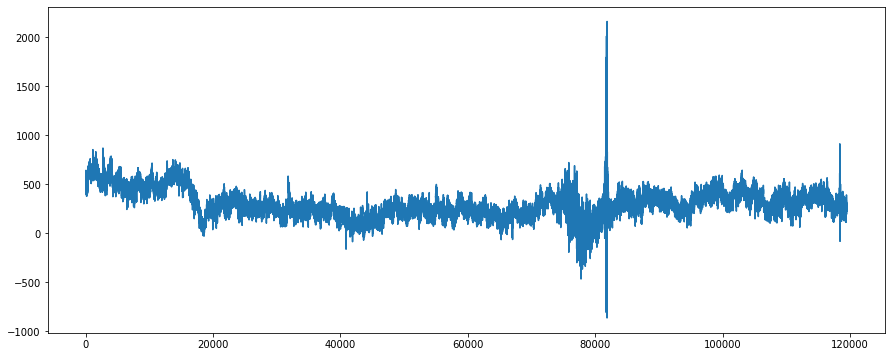

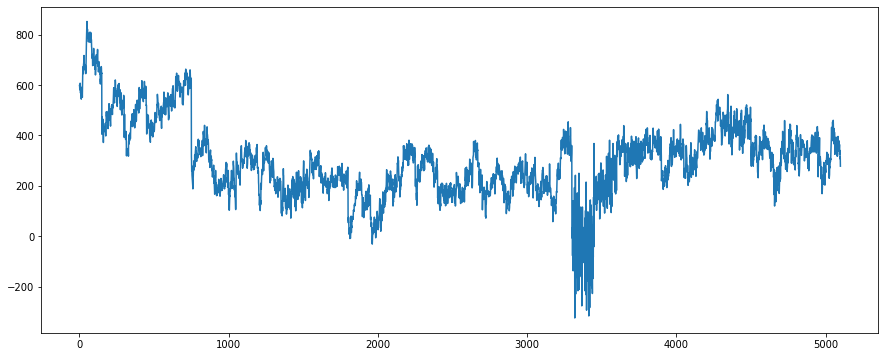

In [ ]:
C4_handstart = []
for i in range(119495):
  if HS[i] == 1:
    C4_handstart.append(C4[i])
 
print(C4_handstart)

fig = plt.figure(figsize=(15, 6))
plt.plot(C4)

fig = plt.figure(figsize=(15, 6))
plt.plot(C4_handstart)

<Figure size 1440x432 with 0 Axes>

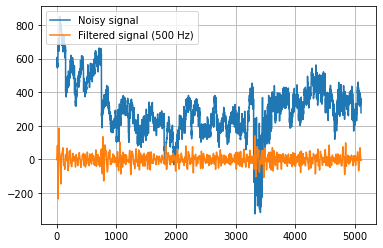

<Figure size 2160x720 with 0 Axes>

In [ ]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 500
lowcut = 7
highcut = 30

# Filter a noisy signal.
#nsamples = int(T * fs)
f0 = 500.0
figure = plt.figure(figsize=(20, 6))
plt.figure(2)
plt.clf()
plt.plot( C4_handstart, label='Noisy signal')

y2 = butter_bandpass_filter(C4_handstart, lowcut, highcut, fs, order=6)

plt.plot( y2, label='Filtered signal (%g Hz)' % f0)
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
#plt.figure(figsize=(40, 10))
plt.show()

#resizing
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
#plt.plot(y, label='Filtered signal (%g Hz)' % f0)
plt.show()

## Feature Extraction C4

In [ ]:
print(len(y2))

5100


In [ ]:
y2 = np.array(y2)
import statistics

median = np.median(y2)
mean = y2.mean()
var = statistics.variance(y2)
std_dev = var ** 0.5
#kurtosis = kurtosis(y)
skewness = skew(y2)
peak2peak = max(y2)-min(y2)

print("variance = ", var)
print("median = ",median)
print("mean = ", mean)
print("Standard Deviation = ", std_dev)
print("kurtosis = ",kurtosis)
print("skewness = ", skewness)
print("Peak to peak = ", peak2peak)

variance =  1118.7123956935911
median =  0.24584183430323842
mean =  0.05268772052140357
Standard Deviation =  33.44715826036035
kurtosis =  0.5837227113134342
skewness =  -0.2666083048818179
Peak to peak =  421.38646357230175


In [ ]:
#1.mean
mne_features.univariate.compute_mean(y2)

0.05268772052140357

In [ ]:
#2.median
median = np.median(y2)
median

0.7050390423177755

In [ ]:
#3.variance
mne_features.univariate.compute_variance(y2)

1118.7123956935911

In [ ]:
#4.std deviation
mne_features.univariate.compute_std(y2)

33.44715826036035

In [ ]:
#5.kurtosis
mne_features.univariate.compute_kurtosis(y2)

6.664406728353263

In [ ]:
#6.skewness
mne_features.univariate.compute_skewness(y2)

-0.2666083048818179

In [ ]:
#7.peak to peak
mne_features.univariate.compute_ptp_amp(y2)

421.38646357230175

In [ ]:
#8.rms
mne_features.univariate.compute_rms(y2)

33.44392046871569

In [ ]:
#9.power spectrum density
mne_features.utils.power_spectrum(500,y2)

(array([4.70437587e-01, 4.08842925e-01, 9.34421580e-01, 1.97879169e+01,
        9.25018166e+01, 7.26163433e+01, 4.36381780e+01, 3.02457873e+01,
        3.16507812e+01, 3.55062499e+01, 3.01324752e+01, 3.20823919e+01,
        1.71774760e+01, 1.61681067e+01, 9.25109238e+00, 6.79706951e+00,
        3.75547461e+00, 1.68211090e+00, 5.64586139e-01, 2.83412626e-01,
        1.21943522e-01, 4.93625873e-02, 2.14381554e-02, 1.63871019e-02,
        3.80408760e-03, 5.24190699e-03, 3.32922156e-03, 2.92800979e-03,
        2.45210772e-03, 1.87747978e-03, 1.89207245e-03, 1.58269293e-03,
        1.25461297e-03, 1.31528735e-03, 1.18789921e-03, 1.08033875e-03,
        1.00538729e-03, 9.51550616e-04, 8.99668060e-04, 8.27001168e-04,
        8.06122710e-04, 7.45683423e-04, 7.07460551e-04, 6.70129151e-04,
        6.38092302e-04, 6.07567656e-04, 5.82267490e-04, 5.53384494e-04,
        5.34700095e-04, 5.07588300e-04, 4.88618950e-04, 4.70695992e-04,
        4.53075831e-04, 4.36068498e-04, 4.20094794e-04, 4.064657

In [ ]:
# 10.Spectral entropy
print(ant.spectral_entropy(y2, sf=500, method='welch', normalize=True))

0.5146914206663175


In [ ]:
# 11.Approximate entropy
print(ant.app_entropy(y2))

0.5965029311962233


In [ ]:
#12.zero crossing
import numpy
# Number of zero-crossings
print(ant.num_zerocross(y2))

zs = numpy.where(numpy.diff(numpy.sign(y2)))[0]
zs

335


array([  16,   30,   58,   80,  113,  143,  162,  166,  181,  205,  233,
        263,  278,  285,  308,  321,  344,  360,  394,  423,  452,  466,
        476,  489,  496,  505,  523,  531,  535,  549,  561,  589,  605,
        610,  621,  635,  637,  649,  661,  671,  681,  686,  697,  708,
        714,  729,  754,  768,  781,  802,  834,  861,  895,  922,  927,
        936,  948,  955,  965,  974,  981,  990,  996, 1009, 1028, 1054,
       1069, 1082, 1097, 1109, 1123, 1139, 1150, 1162, 1175, 1211, 1232,
       1252, 1283, 1319, 1340, 1368, 1380, 1393, 1412, 1431, 1441, 1454,
       1472, 1487, 1500, 1505, 1516, 1528, 1537, 1546, 1559, 1574, 1592,
       1622, 1642, 1646, 1653, 1671, 1698, 1714, 1731, 1742, 1744, 1760,
       1789, 1817, 1833, 1857, 1889, 1912, 1924, 1942, 1956, 1961, 1981,
       2002, 2029, 2036, 2044, 2061, 2065, 2079, 2103, 2119, 2120, 2140,
       2148, 2156, 2174, 2199, 2228, 2253, 2259, 2268, 2282, 2296, 2307,
       2308, 2333, 2348, 2355, 2367, 2401, 2418, 24

## **Cz Channel**

[154, 137, 133, 140, 154, 158, 134, 158, 158, 149, 143, 157, 158, 169, 186, 188, 193, 175, 188, 183, 200, 194, 212, 212, 211, 230, 229, 230, 230, 230, 240, 230, 248, 240, 244, 250, 242, 213, 201, 237, 220, 237, 221, 206, 208, 212, 226, 234, 223, 255, 250, 241, 232, 251, 258, 253, 256, 261, 255, 275, 262, 262, 254, 257, 262, 233, 241, 270, 251, 234, 251, 253, 270, 289, 309, 281, 269, 258, 220, 205, 222, 232, 225, 219, 206, 203, 198, 210, 205, 190, 227, 234, 212, 222, 202, 205, 220, 183, 182, 185, 190, 188, 183, 199, 199, 189, 209, 160, 181, 194, 208, 206, 201, 208, 195, 177, 164, 177, 169, 188, 176, 193, 192, 173, 145, 161, 165, 149, 178, 191, 178, 207, 194, 191, 200, 186, 178, 192, 195, 182, 180, 200, 196, 198, 203, 226, 238, 221, 215, 191, 19, 43, 42, 59, 57, 53, 64, 44, 40, 20, 25, 29, 67, 57, 62, 47, 45, 25, 39, 49, 60, 69, 54, 61, 50, 22, 33, 53, 70, 76, 75, 44, 68, 55, 37, 57, 52, 53, 40, 23, 47, 53, 55, 75, 77, 66, 86, 86, 79, 77, 80, 71, 55, 69, 91, 110, 76, 75, 74, 54, 50, 60, 

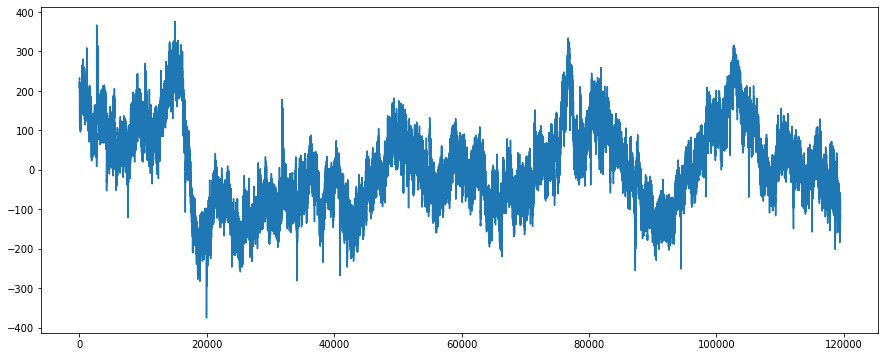

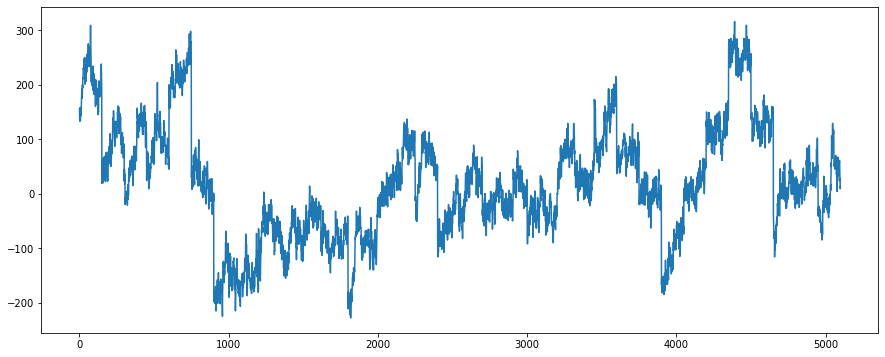

In [ ]:
Cz_handstart = []
for i in range(119495):
  if HS[i] == 1:
    Cz_handstart.append(Cz[i])
 
print(Cz_handstart)

fig = plt.figure(figsize=(15, 6))
plt.plot(Cz)

fig = plt.figure(figsize=(15, 6))
plt.plot(Cz_handstart)

<Figure size 1440x432 with 0 Axes>

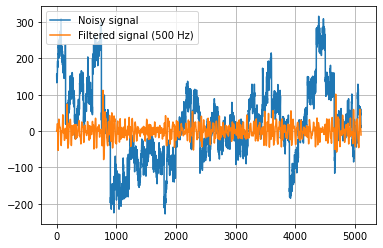

<Figure size 2160x720 with 0 Axes>

In [ ]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 500
lowcut = 7
highcut = 30

# Filter a noisy signal.
#nsamples = int(T * fs)
f0 = 500.0
figure = plt.figure(figsize=(20, 6))
plt.figure(2)
plt.clf()
plt.plot( Cz_handstart, label='Noisy signal')

y3 = butter_bandpass_filter(Cz_handstart, lowcut, highcut, fs, order=6)

plt.plot( y3, label='Filtered signal (%g Hz)' % f0)
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
#plt.figure(figsize=(40, 10))
plt.show()

#resizing
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
#plt.plot(y, label='Filtered signal (%g Hz)' % f0)
plt.show()

In [ ]:
print(len(y3))

5100


In [ ]:
y3 = np.array(y3)
import statistics

median = np.median(y3)
mean = y3.mean()
var = statistics.variance(y3)
std_dev = var ** 0.5
#kurtosis = kurtosis(y)
skewness = skew(y3)
peak2peak = max(y3)-min(y3)

print("variance = ", var)
print("median = ",median)
print("mean = ", mean)
print("Standard Deviation = ", std_dev)
print("kurtosis = ",kurtosis)
print("skewness = ", skewness)
print("Peak to peak = ", peak2peak)

variance =  403.81343984676704
median =  0.034580794848651064
mean =  0.05737570138940578
Standard Deviation =  20.095109849084356
kurtosis =  0.5837227113134342
skewness =  0.2172946546999897
Peak to peak =  190.69264375676795


In [ ]:
#1.mean
mne_features.univariate.compute_mean(y3)

0.05737570138940578

In [ ]:
#2.median
median = np.median(y3)
median

0.034580794848651064

In [ ]:
#3.variance
mne_features.univariate.compute_variance(y3)

403.81343984676704

In [ ]:
#4.std deviation
mne_features.univariate.compute_std(y3)

20.095109849084356

In [ ]:
#5.kurtosis
mne_features.univariate.compute_kurtosis(y3)

4.457191662922427

In [ ]:
#6.skewness
mne_features.univariate.compute_skewness(y3)

0.2172946546999897

In [ ]:
#7.peak to peak
mne_features.univariate.compute_ptp_amp(y3)

190.69264375676795

In [ ]:
#8.rms
mne_features.univariate.compute_rms(y3)

20.093221561313275

In [ ]:
#9.power spectrum density
mne_features.utils.power_spectrum(500,y3)

(array([2.30035758e-01, 1.67868295e-01, 4.99993821e-01, 1.34574284e+01,
        3.61826692e+01, 3.45059700e+01, 2.11840524e+01, 1.49191009e+01,
        1.30513332e+01, 1.52452825e+01, 7.95974279e+00, 8.96866022e+00,
        6.18370818e+00, 6.87433811e+00, 6.03235279e+00, 3.22100748e+00,
        1.66400396e+00, 1.11087325e+00, 3.51040592e-01, 1.58912063e-01,
        5.01151030e-02, 1.73006895e-02, 7.84721827e-03, 4.94136662e-03,
        2.23362900e-03, 1.21671848e-03, 8.96732114e-04, 6.20515065e-04,
        4.43561996e-04, 3.53346890e-04, 2.89214714e-04, 2.29757184e-04,
        2.33076659e-04, 2.18070452e-04, 1.86842728e-04, 1.63141678e-04,
        1.68935586e-04, 1.40051176e-04, 1.35096308e-04, 1.26292068e-04,
        1.22161164e-04, 1.11851345e-04, 1.06149616e-04, 1.00383740e-04,
        9.39498990e-05, 9.17279595e-05, 8.50116839e-05, 8.23619837e-05,
        7.85209794e-05, 7.41776686e-05, 7.18139012e-05, 6.85201381e-05,
        6.60638420e-05, 6.33886457e-05, 6.10109630e-05, 5.880111

In [ ]:
# 10.Spectral entropy
print(ant.spectral_entropy(y3, sf=500, method='welch', normalize=True))

0.5122547703111741


In [ ]:
# 11.Approximate entropy
print(ant.app_entropy(y3))

0.5983298974582381


In [ ]:
#12.zero crossing
import numpy
# Number of zero-crossings
print(ant.num_zerocross(y))

zs = numpy.where(numpy.diff(numpy.sign(y3)))[0]
zs

320


array([  17,   30,   64,   86,   88,   94,  112,  119,  121,  139,  148,
        166,  181,  205,  237,  253,  261,  282,  307,  320,  331,  356,
        382,  413,  446,  463,  478,  485,  489,  509,  524,  529,  538,
        548,  555,  565,  574,  591,  618,  633,  659,  677,  697,  699,
        713,  726,  733,  743,  752,  767,  780,  804,  834,  862,  873,
        879,  895,  917,  929,  953,  980, 1008, 1029, 1036, 1044, 1057,
       1068, 1079, 1100, 1112, 1126, 1138, 1151, 1161, 1166, 1184, 1200,
       1208, 1220, 1228, 1234, 1252, 1280, 1308, 1331, 1350, 1377, 1405,
       1423, 1431, 1442, 1449, 1460, 1469, 1476, 1500, 1517, 1528, 1531,
       1544, 1555, 1566, 1591, 1610, 1621, 1634, 1648, 1669, 1684, 1690,
       1703, 1721, 1735, 1743, 1764, 1779, 1786, 1798, 1812, 1816, 1830,
       1855, 1891, 1910, 1915, 1931, 1967, 1981, 1989, 2001, 2014, 2022,
       2041, 2080, 2114, 2155, 2178, 2199, 2213, 2217, 2228, 2254, 2281,
       2303, 2341, 2370, 2402, 2418, 2429, 2453, 24

## **P3 Channel**

[225, 241, 252, 298, 295, 245, 266, 286, 325, 294, 277, 312, 324, 345, 354, 352, 340, 352, 369, 366, 373, 380, 400, 435, 459, 479, 482, 494, 497, 500, 504, 507, 502, 506, 526, 526, 521, 520, 512, 551, 549, 603, 596, 580, 601, 611, 643, 669, 710, 718, 708, 675, 642, 666, 673, 696, 729, 763, 745, 736, 709, 667, 660, 757, 757, 640, 676, 649, 650, 634, 642, 666, 688, 730, 741, 731, 737, 644, 620, 631, 635, 662, 660, 665, 617, 619, 621, 621, 611, 584, 608, 600, 582, 583, 564, 558, 561, 556, 551, 505, 525, 532, 515, 502, 499, 514, 498, 471, 505, 531, 588, 590, 597, 604, 584, 541, 536, 570, 539, 535, 553, 575, 581, 551, 537, 569, 561, 509, 547, 569, 523, 546, 558, 552, 532, 505, 509, 509, 496, 462, 460, 501, 466, 420, 483, 479, 475, 473, 451, 412, 268, 319, 330, 353, 338, 326, 344, 314, 279, 265, 251, 268, 307, 254, 275, 304, 319, 289, 292, 298, 291, 284, 275, 278, 264, 251, 248, 258, 264, 279, 305, 291, 315, 327, 332, 336, 347, 368, 300, 291, 308, 305, 320, 360, 389, 357, 358, 364, 367, 357,

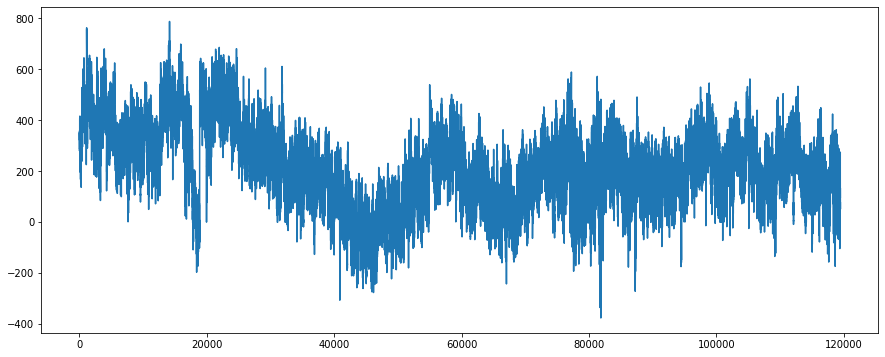

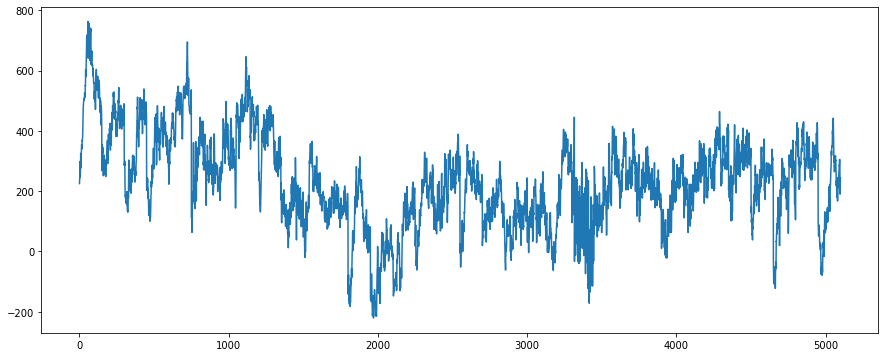

In [ ]:
P3_handstart = []
for i in range(119495):
  if HS[i] == 1:
    P3_handstart.append(P3[i])
 
print(P3_handstart)

fig = plt.figure(figsize=(15, 6))
plt.plot(P3)

fig = plt.figure(figsize=(15, 6))
plt.plot(P3_handstart)

<Figure size 1440x432 with 0 Axes>

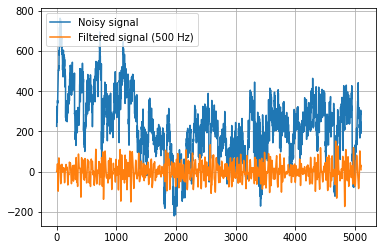

<Figure size 2160x720 with 0 Axes>

In [ ]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 500
lowcut = 7
highcut = 30

# Filter a noisy signal.
#nsamples = int(T * fs)
f0 = 500.0
figure = plt.figure(figsize=(20, 6))
plt.figure(2)
plt.clf()
plt.plot( P3_handstart, label='Noisy signal')

y4 = butter_bandpass_filter(P3_handstart, lowcut, highcut, fs, order=6)

plt.plot( y4, label='Filtered signal (%g Hz)' % f0)
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
#plt.figure(figsize=(40, 10))
plt.show()

#resizing
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
#plt.plot(y, label='Filtered signal (%g Hz)' % f0)
plt.show()

In [ ]:
print(len(y4))

5100


In [ ]:
y4 = np.array(y4)
import statistics

median = np.median(y4)
mean = y4.mean()
var = statistics.variance(y4)
std_dev = var ** 0.5
#kurtosis = kurtosis(y)
skewness = skew(y4)
peak2peak = max(y4)-min(y4)

print("variance = ", var)
print("median = ",median)
print("mean = ", mean)
print("Standard Deviation = ", std_dev)
print("kurtosis = ",kurtosis)
print("skewness = ", skewness)
print("Peak to peak = ", peak2peak)

variance =  1925.5799345106705
median =  0.05160647940777765
mean =  0.11176561084089438
Standard Deviation =  43.88143040638797
kurtosis =  0.5837227113134342
skewness =  -0.09965434531220589
Peak to peak =  325.3894079130064


In [ ]:
#1.mean
mne_features.univariate.compute_mean(y4)

0.11176561084089438

In [ ]:
#2.median
median = np.median(y4)
median

0.05160647940777765

In [ ]:
#3.variance
mne_features.univariate.compute_variance(y4)

1925.5799345106702

In [ ]:
#4.std deviation
mne_features.univariate.compute_std(y4)

43.88143040638796

In [ ]:
#5.kurtosis
mne_features.univariate.compute_kurtosis(y4)

3.298954762852315

In [ ]:
#6.skewness
mne_features.univariate.compute_skewness(y4)

-0.09965434531220589

In [ ]:
#7.peak to peak
mne_features.univariate.compute_ptp_amp(y4)

325.3894079130064

In [ ]:
#8.rms
mne_features.univariate.compute_rms(y4)

43.8772704411908

In [ ]:
#9.power spectrum density
mne_features.utils.power_spectrum(500,y4)

(array([5.30179711e-01, 3.71957180e-01, 2.30199791e+00, 6.25148287e+01,
        1.75470155e+02, 1.68275221e+02, 1.02116733e+02, 6.37193029e+01,
        6.69850064e+01, 8.16156942e+01, 6.20874286e+01, 3.48403836e+01,
        3.98185385e+01, 3.57220999e+01, 1.77385208e+01, 9.15320371e+00,
        5.97615823e+00, 3.68655849e+00, 1.03980764e+00, 4.02544068e-01,
        1.99279493e-01, 9.84201709e-02, 3.37051578e-02, 1.67412462e-02,
        9.61430886e-03, 5.08383419e-03, 3.66071822e-03, 2.58905841e-03,
        2.57680401e-03, 1.42521469e-03, 1.42805562e-03, 1.27695583e-03,
        1.25035861e-03, 1.04950943e-03, 9.96174876e-04, 8.91575154e-04,
        8.13496184e-04, 7.99886237e-04, 7.00608844e-04, 6.84526419e-04,
        6.45852278e-04, 6.10700072e-04, 5.71795541e-04, 5.43813321e-04,
        5.24298462e-04, 4.89833746e-04, 4.74495057e-04, 4.51216874e-04,
        4.36280157e-04, 4.14620308e-04, 3.99043959e-04, 3.83083165e-04,
        3.69860823e-04, 3.55520428e-04, 3.43450383e-04, 3.317565

In [ ]:
# 10.Spectral entropy
print(ant.spectral_entropy(y4, sf=500, method='welch', normalize=True))

0.5075832104492516


In [ ]:
# 11.Approximate entropy
print(ant.app_entropy(y4))

0.6143199783954083


In [ ]:
#12.zero crossing
import numpy
# Number of zero-crossings
print(ant.num_zerocross(y4))

zs = numpy.where(numpy.diff(numpy.sign(y4)))[0]
zs

318


array([  17,   31,   60,   81,   95,   98,  113,  114,  125,  140,  178,
        206,  236,  257,  274,  286,  309,  320,  332,  357,  395,  413,
        424,  428,  446,  468,  481,  509,  540,  573,  606,  615,  619,
        645,  664,  688,  696,  701,  712,  725,  735,  744,  759,  769,
        778,  802,  827,  864,  874,  882,  894,  902,  916,  943,  974,
        988, 1001, 1013, 1027, 1040, 1051, 1055, 1068, 1082, 1098, 1112,
       1127, 1140, 1153, 1161, 1171, 1186, 1202, 1217, 1234, 1253, 1283,
       1314, 1336, 1365, 1381, 1408, 1425, 1433, 1437, 1447, 1459, 1471,
       1480, 1492, 1494, 1503, 1517, 1522, 1535, 1550, 1557, 1568, 1592,
       1616, 1647, 1661, 1666, 1678, 1686, 1697, 1710, 1717, 1730, 1756,
       1769, 1777, 1787, 1799, 1809, 1818, 1831, 1854, 1887, 1917, 1934,
       1942, 1956, 1966, 1979, 2002, 2013, 2020, 2037, 2056, 2069, 2082,
       2099, 2113, 2130, 2158, 2178, 2199, 2213, 2218, 2231, 2256, 2282,
       2306, 2331, 2353, 2359, 2375, 2405, 2431, 24

## **P4 Channel**

[136, 135, 122, 108, 123, 132, 119, 124, 149, 144, 132, 145, 144, 198, 217, 223, 221, 210, 211, 199, 218, 244, 287, 278, 281, 306, 313, 353, 366, 372, 391, 373, 349, 351, 384, 362, 350, 354, 356, 374, 386, 402, 398, 400, 403, 446, 464, 519, 576, 604, 609, 564, 518, 533, 553, 561, 593, 628, 609, 602, 598, 587, 570, 592, 610, 590, 596, 592, 564, 531, 534, 523, 570, 614, 602, 564, 571, 525, 491, 491, 514, 524, 513, 495, 457, 450, 463, 478, 435, 418, 448, 459, 443, 437, 437, 440, 462, 456, 426, 410, 419, 441, 468, 423, 399, 429, 409, 359, 376, 372, 451, 457, 429, 460, 425, 413, 430, 444, 443, 444, 437, 459, 495, 425, 357, 401, 409, 376, 412, 408, 369, 402, 397, 364, 341, 373, 356, 335, 345, 324, 311, 299, 274, 257, 294, 348, 380, 362, 335, 289, 258, 325, 380, 377, 338, 353, 341, 286, 287, 282, 285, 277, 322, 301, 321, 354, 353, 322, 338, 349, 351, 357, 334, 343, 320, 294, 272, 321, 357, 365, 397, 358, 393, 401, 374, 386, 397, 410, 373, 368, 361, 361, 394, 430, 436, 411, 424, 450, 475, 444,

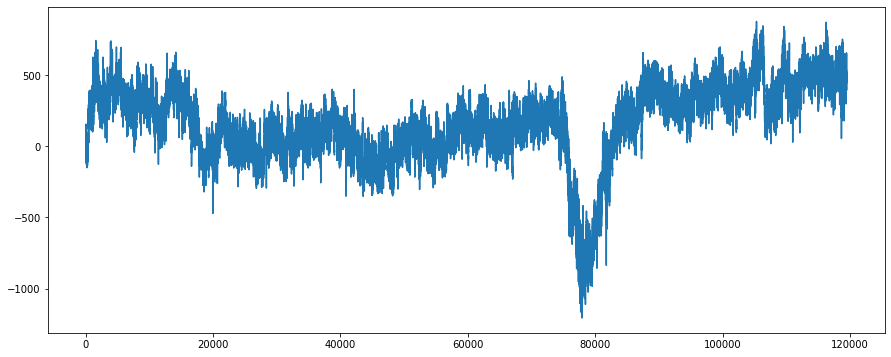

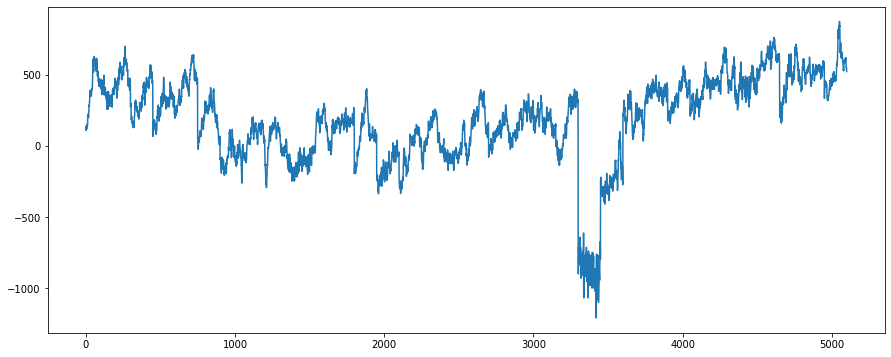

In [ ]:
P4_handstart = []
for i in range(119495):
  if HS[i] == 1:
    P4_handstart.append(P4[i])
 
print(P4_handstart)

fig = plt.figure(figsize=(15, 6))
plt.plot(P4)

fig = plt.figure(figsize=(15, 6))
plt.plot(P4_handstart)

<Figure size 1440x432 with 0 Axes>

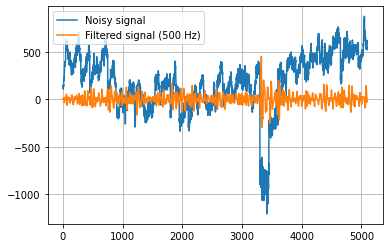

<Figure size 2160x720 with 0 Axes>

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 500
lowcut = 7
highcut = 30

# Filter a noisy signal.
#nsamples = int(T * fs)
f0 = 500.0
figure = plt.figure(figsize=(20, 6))
plt.figure(2)
plt.clf()
plt.plot( P4_handstart, label='Noisy signal')

y5 = butter_bandpass_filter(P4_handstart, lowcut, highcut, fs, order=6)

plt.plot( y5, label='Filtered signal (%g Hz)' % f0)
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
#plt.figure(figsize=(40, 10))
plt.show()

#resizing
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
#plt.plot(y, label='Filtered signal (%g Hz)' % f0)
plt.show()

## Feature Extraction

In [ ]:
print(len(y5))

5100


In [ ]:
y5 = np.array(y5)
import statistics

median = np.median(y5)
mean = y5.mean()
var = statistics.variance(y5)
std_dev = var ** 0.5
#kurtosis = kurtosis(y)
skewness = skew(y5)
peak2peak = max(y5)-min(y5)

print("variance = ", var)
print("median = ",median)
print("mean = ", mean)
print("Standard Deviation = ", std_dev)
print("kurtosis = ",kurtosis)
print("skewness = ", skewness)
print("Peak to peak = ", peak2peak)

variance =  3295.3997629555597
median =  -0.32692753321886037
mean =  0.1257265525679445
Standard Deviation =  57.405572577543026
kurtosis =  0.5837227113134342
skewness =  0.34114623626515317
Peak to peak =  747.8493656390414


In [ ]:
#1.mean
mne_features.univariate.compute_mean(y5)

0.1257265525679445

In [ ]:
#2.median
median = np.median(y5)
median

-0.32692753321886037

In [ ]:
#3.variance
mne_features.univariate.compute_variance(y5)

3295.3997629555593

In [ ]:
#4.std deviation
mne_features.univariate.compute_std(y5)

57.40557257754302

In [ ]:
#5.kurtosis
mne_features.univariate.compute_kurtosis(y5)

7.738082933219697

In [ ]:
#6.skewness
mne_features.univariate.compute_skewness(y5)

0.34114623626515317

In [ ]:
#7.peak to peak
mne_features.univariate.compute_ptp_amp(y5)

747.8493656390414

In [ ]:
#8.rms
mne_features.univariate.compute_rms(y5)

57.400081997374485

In [ ]:
#9.power spectrum density
mne_features.utils.power_spectrum(500,y5)

(array([2.93304288e+00, 2.21514914e+00, 3.23100956e+00, 7.92001694e+01,
        3.20981571e+02, 2.64096623e+02, 1.72311558e+02, 1.21689835e+02,
        8.71781712e+01, 9.23793872e+01, 5.64585950e+01, 3.28230951e+01,
        2.87832531e+01, 4.10152379e+01, 2.42446007e+01, 1.06831537e+01,
        7.54638800e+00, 3.19492908e+00, 9.04283531e-01, 8.36788945e-01,
        2.14932033e-01, 9.32411526e-02, 3.95201600e-02, 3.05717096e-02,
        2.03533295e-02, 1.69114159e-02, 1.44208974e-02, 1.20264697e-02,
        1.15019249e-02, 1.08098799e-02, 8.40746739e-03, 8.32886362e-03,
        7.29502719e-03, 6.80692668e-03, 6.18623116e-03, 5.91961802e-03,
        5.45306747e-03, 5.25450881e-03, 4.86356401e-03, 4.63356015e-03,
        4.30745080e-03, 4.14901279e-03, 3.93097249e-03, 3.71955978e-03,
        3.54514684e-03, 3.37384094e-03, 3.24096976e-03, 3.10420635e-03,
        2.97352295e-03, 2.85489681e-03, 2.73919219e-03, 2.64107478e-03,
        2.54063615e-03, 2.44653450e-03, 2.36823022e-03, 2.281304

In [ ]:
# 10.Spectral entropy
print(ant.spectral_entropy(y5, sf=500, method='welch', normalize=True))

0.49301959004030754


In [ ]:
# 11.Approximate entropy
print(ant.app_entropy(y5))

0.5701607124785464


In [ ]:
#12.zero crossing
import numpy
# Number of zero-crossings
print(ant.num_zerocross(y5))

zs = numpy.where(numpy.diff(numpy.sign(y5)))[0]
zs

291


array([  17,   31,   44,   50,   64,   80,  109,  140,  164,  192,  218,
        220,  234,  257,  274,  288,  309,  322,  333,  356,  379,  411,
        443,  464,  479,  507,  535,  550,  557,  573,  582,  589,  618,
        647,  664,  673,  679,  690,  699,  703,  711,  729,  755,  769,
        779,  801,  833,  861,  874,  879,  895,  921,  930,  942,  969,
        988, 1000, 1009, 1016, 1024, 1030, 1043, 1050, 1054, 1069, 1091,
       1098, 1110, 1128, 1142, 1152, 1164, 1173, 1185, 1198, 1204, 1232,
       1252, 1281, 1315, 1340, 1368, 1382, 1397, 1405, 1411, 1422, 1431,
       1442, 1461, 1473, 1487, 1495, 1498, 1513, 1527, 1536, 1546, 1559,
       1574, 1594, 1621, 1649, 1679, 1703, 1723, 1724, 1741, 1758, 1760,
       1774, 1804, 1805, 1816, 1831, 1855, 1887, 1908, 1925, 1946, 1959,
       1963, 1981, 2003, 2039, 2058, 2068, 2078, 2101, 2117, 2130, 2156,
       2179, 2203, 2229, 2242, 2246, 2255, 2263, 2271, 2281, 2296, 2328,
       2369, 2386, 2418, 2444, 2477, 2491, 2503, 25

## **Pz Channel**

[336, 325, 318, 311, 339, 347, 330, 356, 363, 328, 322, 363, 384, 414, 433, 422, 417, 425, 435, 429, 458, 464, 482, 476, 480, 516, 528, 532, 523, 529, 549, 550, 549, 535, 547, 552, 544, 531, 525, 538, 533, 570, 557, 543, 548, 568, 617, 650, 659, 672, 681, 643, 619, 632, 648, 663, 677, 708, 695, 700, 701, 687, 694, 709, 717, 673, 658, 676, 650, 622, 649, 664, 688, 726, 729, 699, 699, 648, 609, 600, 611, 624, 623, 601, 563, 564, 560, 583, 562, 555, 592, 572, 556, 560, 547, 561, 572, 540, 527, 494, 515, 512, 518, 504, 488, 496, 500, 465, 474, 492, 559, 558, 543, 554, 526, 522, 519, 538, 517, 518, 525, 541, 529, 506, 508, 506, 485, 467, 503, 523, 504, 510, 490, 472, 469, 468, 455, 469, 459, 424, 402, 413, 391, 393, 420, 454, 471, 445, 418, 395, 169, 216, 236, 263, 241, 237, 251, 201, 191, 179, 183, 210, 215, 182, 209, 232, 233, 209, 221, 233, 228, 221, 211, 211, 193, 162, 156, 197, 218, 228, 250, 226, 240, 243, 243, 273, 289, 296, 254, 238, 232, 239, 271, 295, 310, 293, 314, 328, 316, 329,

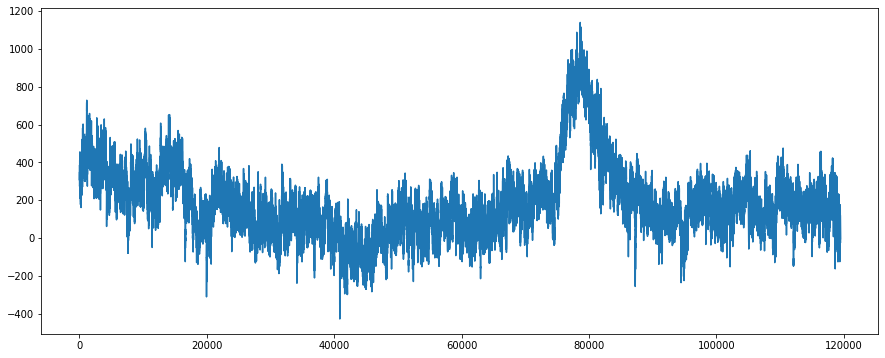

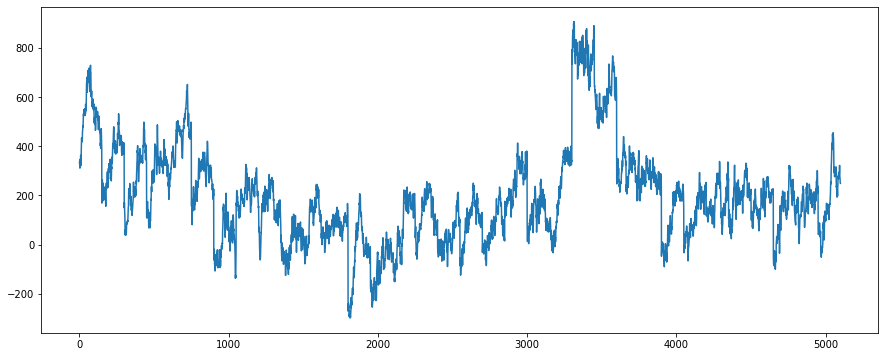

In [ ]:
Pz_handstart = []
for i in range(119495):
  if HS[i] == 1:
    Pz_handstart.append(Pz[i])
 
print(Pz_handstart)

fig = plt.figure(figsize=(15, 6))
plt.plot(Pz)

fig = plt.figure(figsize=(15, 6))
plt.plot(Pz_handstart)

## Preprocess filter(ButterWorth)

<Figure size 1440x432 with 0 Axes>

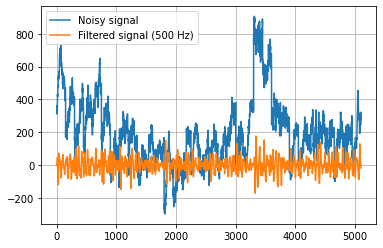

<Figure size 2160x720 with 0 Axes>

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 500
lowcut = 7
highcut = 30

# Filter a noisy signal.
#nsamples = int(T * fs)
f0 = 500.0
figure = plt.figure(figsize=(20, 6))
plt.figure(2)
plt.clf()
plt.plot( Pz_handstart, label='Noisy signal')

y6 = butter_bandpass_filter(Pz_handstart, lowcut, highcut, fs, order=6)

plt.plot( y6, label='Filtered signal (%g Hz)' % f0)
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
#plt.figure(figsize=(40, 10))
plt.show()

#resizing
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
#plt.plot(y, label='Filtered signal (%g Hz)' % f0)
plt.show()

In [ ]:
print(len(y6))

5100


In [ ]:
y6 = np.array(y6)
import statistics

median = np.median(y6)
mean = y6.mean()
var = statistics.variance(y6)
std_dev = var ** 0.5
#kurtosis = kurtosis(y)
skewness = skew(y6)
peak2peak = max(y6)-min(y6)

print("variance = ", var)
print("median = ",median)
print("mean = ", mean)
print("Standard Deviation = ", std_dev)
print("kurtosis = ",kurtosis)
print("skewness = ", skewness)
print("Peak to peak = ", peak2peak)

variance =  2026.4256564498812
median =  0.44806538618045516
mean =  0.10873005304867735
Standard Deviation =  45.015837840141124
kurtosis =  0.5837227113134342
skewness =  0.008007183084781168
Peak to peak =  347.5248386929779


In [ ]:
#1.mean
mne_features.univariate.compute_mean(y6)

0.10873005304867735

In [ ]:
#2.median
median = np.median(y6)
median

0.44806538618045516

In [ ]:
#3.variance
mne_features.univariate.compute_variance(y6)

2026.4256564498812

In [ ]:
#4.std deviation
mne_features.univariate.compute_std(y6)

45.015837840141124

In [ ]:
#5.kurtosis
mne_features.univariate.compute_kurtosis(y6)

3.5940308617871337

In [ ]:
#6.skewness
mne_features.univariate.compute_skewness(y6)

0.008007183084781168

In [ ]:
#7.peak to peak
mne_features.univariate.compute_ptp_amp(y6)

347.5248386929779

In [ ]:
#8.rms
mne_features.univariate.compute_rms(y6)

45.01155563086336

In [ ]:
#9.power spectrum density
mne_features.utils.power_spectrum(500,y6)

(array([9.25942231e-01, 6.49030783e-01, 1.92393441e+00, 6.95870997e+01,
        2.34599510e+02, 1.90411293e+02, 1.09051680e+02, 7.56730333e+01,
        5.22561675e+01, 5.34743087e+01, 3.55241002e+01, 3.01637878e+01,
        2.61806435e+01, 2.54867859e+01, 2.08047283e+01, 1.07804048e+01,
        5.71300381e+00, 2.67381224e+00, 5.85457025e-01, 3.27590352e-01,
        9.20513737e-02, 6.99190599e-02, 2.05401441e-02, 2.01218260e-02,
        7.81809993e-03, 8.48983068e-03, 4.20386290e-03, 5.43524114e-03,
        3.91931554e-03, 3.66101217e-03, 3.04565652e-03, 2.91553489e-03,
        2.57198356e-03, 2.59644824e-03, 2.17394991e-03, 2.23766057e-03,
        1.97273128e-03, 1.91522727e-03, 1.77994180e-03, 1.68140121e-03,
        1.61471617e-03, 1.50807660e-03, 1.44881093e-03, 1.36634942e-03,
        1.30815137e-03, 1.25308689e-03, 1.19623163e-03, 1.14765613e-03,
        1.10705104e-03, 1.05426290e-03, 1.01827667e-03, 9.79496112e-04,
        9.45860872e-04, 9.09722090e-04, 8.80803679e-04, 8.519800

In [ ]:
# 10.Spectral entropy
print(ant.spectral_entropy(y6, sf=500, method='welch', normalize=True))

0.48986582839543247


In [ ]:
# 11.Approximate entropy
print(ant.app_entropy(y6))

0.6016482559127256


In [ ]:
#12.zero crossing
import numpy
# Number of zero-crossings
print(ant.num_zerocross(y6))

zs = numpy.where(numpy.diff(numpy.sign(y6)))[0]
zs

301


array([  17,   30,   61,   84,  112,  141,  179,  206,  236,  255,  275,
        286,  307,  319,  331,  356,  378,  412,  443,  461,  479,  508,
        538,  571,  609,  610,  618,  645,  664,  690,  694,  702,  712,
        726,  736,  740,  758,  770,  779,  801,  831,  862,  872,  881,
        895,  918,  930,  948,  977,  990,  998, 1020, 1030, 1041, 1049,
       1055, 1068, 1082, 1101, 1112, 1124, 1140, 1155, 1158, 1170, 1186,
       1196, 1205, 1232, 1252, 1283, 1313, 1336, 1365, 1381, 1409, 1428,
       1429, 1439, 1452, 1456, 1467, 1478, 1500, 1517, 1524, 1534, 1547,
       1555, 1568, 1592, 1618, 1646, 1662, 1667, 1678, 1703, 1722, 1728,
       1738, 1769, 1799, 1809, 1816, 1831, 1855, 1888, 1910, 1932, 1943,
       1981, 2001, 2012, 2018, 2036, 2057, 2067, 2079, 2100, 2126, 2135,
       2158, 2180, 2201, 2228, 2243, 2244, 2267, 2283, 2305, 2333, 2372,
       2385, 2390, 2401, 2420, 2431, 2449, 2463, 2477, 2490, 2506, 2519,
       2530, 2545, 2558, 2578, 2604, 2633, 2664, 26